# 공유 드라이브 데이터 아이디 

In [ ]:
# images.npy.zip - 1nOmp0viaKB1Ne7hwMyKH8XRXxESh06uw

# masks.npy.zip - 15it_LWN8JaYjbGcNRJhmxIySzX2xwfXJ

# label.npy - 1d_NhZWL-jhyZrn-Qd460328S37blVT8x

# 데이터 다운로드 / Unzip

In [1]:
!gdown 1nOmp0viaKB1Ne7hwMyKH8XRXxESh06uw
!gdown 15it_LWN8JaYjbGcNRJhmxIySzX2xwfXJ
!gdown 1d_NhZWL-jhyZrn-Qd460328S37blVT8x

Downloading...
From: https://drive.google.com/uc?id=1nOmp0viaKB1Ne7hwMyKH8XRXxESh06uw
To: /content/images.npy.zip
100% 878M/878M [00:06<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=15it_LWN8JaYjbGcNRJhmxIySzX2xwfXJ
To: /content/masks.npy.zip
100% 1.69M/1.69M [00:00<00:00, 201MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d_NhZWL-jhyZrn-Qd460328S37blVT8x
To: /content/labels.npy
100% 24.6k/24.6k [00:00<00:00, 36.7MB/s]


In [2]:
!unzip /content/images.npy.zip
!unzip /content/masks.npy.zip

Archive:  /content/images.npy.zip
  inflating: images.npy              
Archive:  /content/masks.npy.zip
  inflating: masks.npy               


# 빈 폴더 만들기 / 빈 폴더 안으로 데이터 이동 

In [ ]:
!mkdir Kaggle
!mkdir Kaggle/input

In [7]:
!mv /content/images.npy /content/Kaggle/input
!mv /content/masks.npy /content/Kaggle/input
!mv /content/labels.npy /content/Kaggle/input

# Data Load

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, subdir, filenames in tqdm(os.walk('/kaggle/input'), total = 3):
#     for filename in filenames:
#         filepath = (os.path.join(dirname, filename))
#         print("loading from", filepath)
#         if "images" in filename:
#             images = np.load(filepath, allow_pickle = True)
#         elif "masks" in filename:
#             masks = np.load(filepath, allow_pickle = True)
#         else:
#             labels = np.load(filepath, allow_pickle = True)


images = np.load('/content/Kaggle/input/images.npy', allow_pickle = True)
masks = np.load('/content/Kaggle/input/masks.npy', allow_pickle = True)
labels = np.load('/content/Kaggle/input/labels.npy', allow_pickle = True)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exploring data

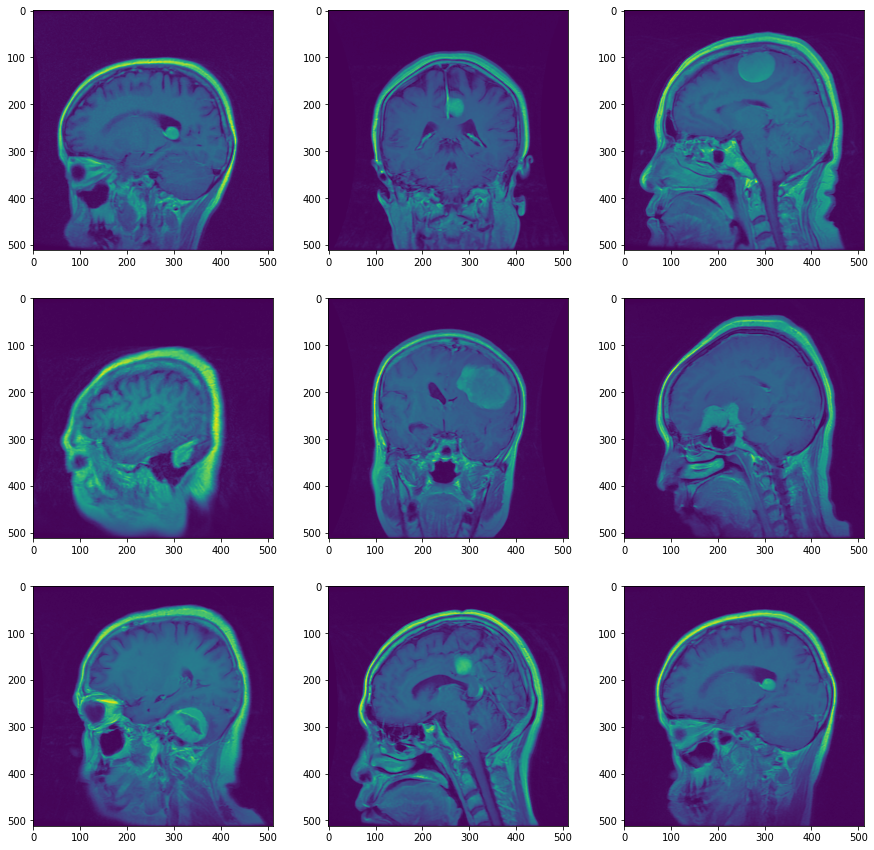

In [23]:
sample_number = 9
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(sample_number):
    subplot = ax[int(i//3), int(i%3)]
    subplot.imshow(images[i])
plt.show()

In [11]:
trainset = np.column_stack((images, masks, labels))
print(trainset.shape)
# 3064x3x512x512
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(trainset, test_size = 0.1)
trainset, validset = train_test_split(trainset, test_size = 0.05)
print('size of trainset, testset and validset is',len(trainset), len(testset), len(validset))

(3064, 3)
size of trainset, testset and validset is 2619 307 138


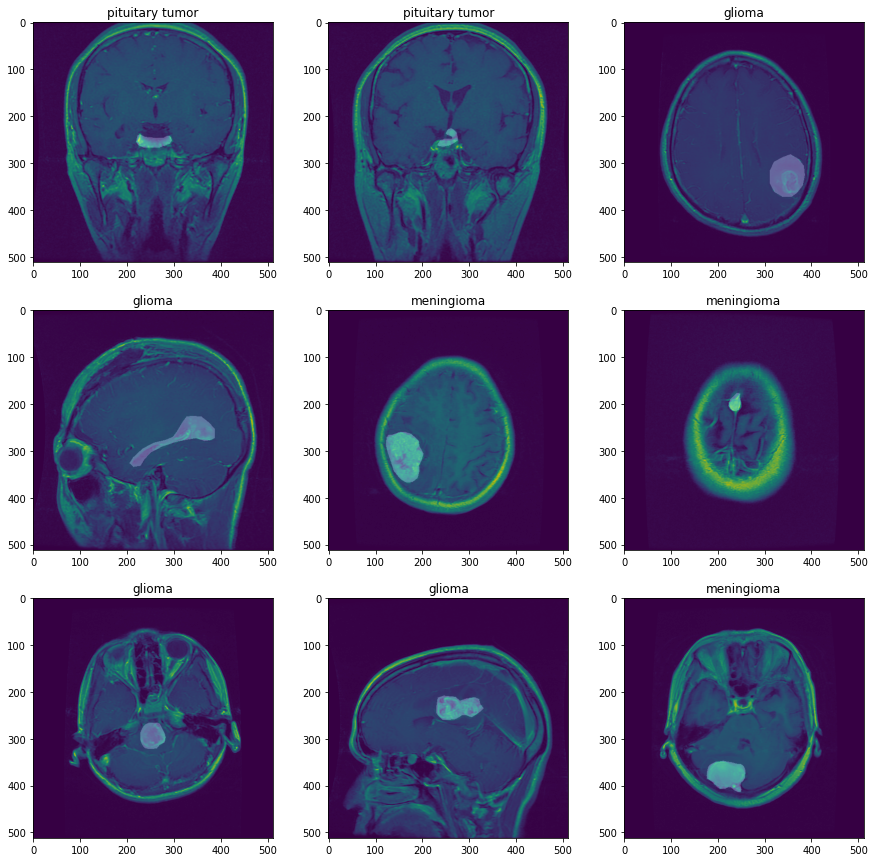

In [12]:
classes = ["meningioma", "glioma", "pituitary tumor"] 

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(sample_number):
    subplot = ax[int(i//3), int(i%3)]
    subplot.imshow(trainset[i][0])
    subplot.set_title(classes[trainset[i][2]-1])
    subplot.imshow(trainset[i][1], cmap='gray', alpha=0.2)
plt.show()

In [13]:
import torch
import torch.nn as nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 4
workers = 4
print("device available: ", device)

device available:  cuda:0


# Helper functions

In [14]:
import torchvision.transforms as transform
import torchvision.transforms.functional as TF
import random
from PIL import Image

random.seed(123)

class Resize(object):
    def __init__(self, size=216):
        self.size = size
    
    def __call__(self, sample):
        image, mask, label = sample
        image = TF.resize(image, size=(self.size, self.size), interpolation=Image.NEAREST)
        mask = TF.resize(mask, size = (self.size, self.size), interpolation=Image.NEAREST)
        return image, mask, label
    

class toPIL(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, mask, label = sample
        image = TF.to_pil_image(image.astype(np.float32))
        mask = TF.to_pil_image(mask.astype(np.float32))
        return image, mask, label

    
class toTensor(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, mask, label = sample
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask, label
    
    
class Rotate(object):
    def __init__(self, p):
        self.p = p
        
    def __call__(self, sample):
        image, mask, label = sample
        if random.random() < self.p:
            angle = random.randint(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        return image, mask, label
    
    
class Flip(object):
    def __init__(self, p):
        self.p = p
        
    def __call__(self, sample):
        image, mask, label = sample
        if random.random() < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        return image, mask, label
    

class Crop(object):
    def __init__(self, p):
        self.p = p
    
    def __call__(self, sample):
        image, mask, label = sample
        if random.random() < self.p:
            size = image.size[1]
            crop_size = random.randint(int(size*0.5), size)
            image = TF.center_crop(image, output_size=crop_size)
            mask = TF.center_crop(mask, output_size=crop_size)
        return image, mask, label
    
    
class Padding(object):
    def __init__(self, size):
        super(Padding, self).__init__()
        self.size = size
        
    def __call__(self, sample):
        image, mask, label = sample
        w, h = image.size
        if (w < self.size):
            image = TF.pad(image, padding = (self.size-w)//2, fill=0)
            mask = TF.pad(mask, padding = (self.size-w)//2, fill=0)
        return image, mask, label
    
class ZoomOut(object):
    def __init__(self, p):
        super(ZoomOut, self).__init__()
        self.p = p
        
    def __call__(self, sample):
        image, mask, label = sample
        w, h = image.size
        if (random.random() < self.p):
            resize = Resize(random.randint(int(0.5*w), int(.95*w)))
            pad = Padding(w)
            sample = resize(sample)
            sample = pad(sample)
        return sample
    
    
def toNumpy(sample):
    image, mask, label = sample
    image = np.array(image)
    mask = np.array(mask)
    return image, mask, label


def normalize(sample):
    image, mask, label = sample
    m, s = np.mean(image), np.std(image)
    image = (image - m)/s
    return image, mask, label


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


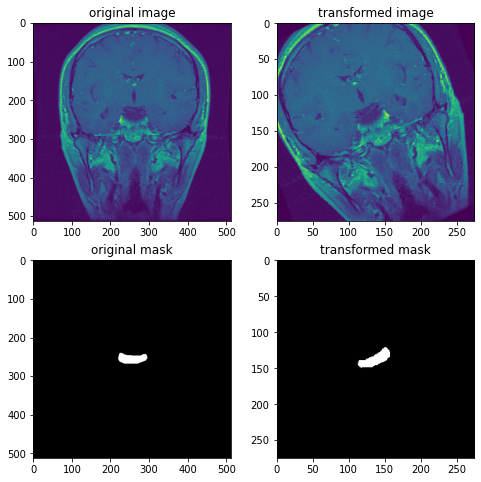

In [15]:
def getTransform(rotate, crop, flip, zoom):
    return transform.Compose([
        Rotate(rotate),
        ZoomOut(zoom),
        Crop(crop),
        Flip(flip),
    ])

func = toPIL()
testimg = func(trainset[0])
trans = getTransform(rotate=1, crop=1, flip=1, zoom=1 )
test = trans(testimg)
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(np.array(testimg[0]))
ax[0, 0].set_title("original image")
ax[0, 1].imshow(np.array(test[0]))
ax[0, 1].set_title('transformed image')
ax[1, 0].imshow(np.array(testimg[1]), cmap='gray')
ax[1, 0].set_title('original mask')
ax[1, 1].imshow(np.array(test[1]), cmap='gray')
ax[1, 1].set_title('transformed mask')
plt.show()

# Dataset class and DataLoader

In [16]:
from torch.utils.data import Dataset, DataLoader
input_size = 128
class MRIDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        self.data = data
        self.transform = transform
        self.train = train
        self.data = [normalize(i) for i in self.data]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        sample = self.data[i]
        
        to_pil = toPIL()
        sample = to_pil(sample)
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        resize_func = Resize(input_size)
        sample = resize_func(sample)
        sample = toNumpy(sample)
        
        image, mask, label = sample
        target_label = np.zeros((3, 1, 1))
        target_label[label-1, 0, 0] = 1
        label = target_label
                
        image = torch.from_numpy(image.astype(np.float32))
        mask = torch.from_numpy(mask.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))
        
        image = torch.unsqueeze(image, dim = 0)
        mask = torch.unsqueeze(mask, dim = 0)

        
        return image, mask, label
    
trainset = MRIDataset(trainset, transform = getTransform(.8, .8, .8, .7)) 
testset  = MRIDataset(testset)
validset = MRIDataset(validset)

In [19]:
# target_label = np.zeros((3, 1, 1))
# print(target_label[0][0])

[0.]


In [17]:
# target_label = np.zeros((3, 1, 1))

# target_label[1, 0, 0] = 1
# target_label

array([[[0.]],

       [[1.]],

       [[0.]]])

In [17]:
def getDataLoader(dataset, batch = batch_size):
    dataloader = DataLoader(
        dataset, 
        batch_size = batch,
        shuffle = True,
        num_workers = workers
    )
    return dataloader

testLoader  = getDataLoader(testset)
trainLoader = getDataLoader(trainset)
validLoader = getDataLoader(validset)

# Define model

In [18]:
from collections import OrderedDict

in_features = 128

class Unet(nn.Module):
    def __init__(self, in_channels = 1, out_channel = 1, init_features=in_features):
        super(Unet, self).__init__()
        self.in_channels = 1
        self.out_channels = 3
        self.init_features = init_features
        
        self.encoder1 = self.__block__(inchannels = in_channels,
                                      outchannels = init_features)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.encoder2 = self.__block__(inchannels = init_features,
                                      outchannels = 2*init_features)
        self.encoder3 = self.__block__(inchannels = 2*init_features,
                                      outchannels = 4*init_features)
        self.encoder4 = self.__block__(inchannels = 4*init_features,
                                      outchannels = 8*init_features)
        self.bottle   = self.__block__(inchannels = 8*init_features,
                                      outchannels = 16*init_features)
        self.upconv4  = nn.ConvTranspose2d(
            in_channels = 16*init_features, out_channels = 8 * init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder4 = self.__block__(inchannels = 16*init_features,
                                      outchannels = 8*init_features)
        self.upconv3  = nn.ConvTranspose2d(
            in_channels = 8 * init_features, out_channels = 4 * init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder3 = self.__block__(inchannels = 8*init_features,
                                      outchannels = 4*init_features)
        self.upconv2 = nn.ConvTranspose2d(
            in_channels = 4 * init_features, out_channels = 2 * init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder2 = self.__block__(inchannels = 4*init_features,
                                      outchannels = 2*init_features)
        self.upconv1 = nn.ConvTranspose2d(
            in_channels = 2 * init_features, out_channels = init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder1 = self.__block__(inchannels = 2*init_features, 
                                      outchannels = init_features)
        self.final = nn.Conv2d(in_channels = init_features, out_channels = out_channel, kernel_size=1)
        
        self.sub_final = self.__fc__(16*init_features)
        
            
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottom = self.bottle(self.pool(enc4))
        pred_label = self.sub_final(bottom)
        
        dec = self.upconv4(bottom)
        dec = torch.cat((dec, enc4), dim=1)
        dec = self.decoder4(dec)
        
        dec = self.upconv3(dec)
        dec = torch.cat((dec, enc3), dim=1)
        dec = self.decoder3(dec)
        
        dec = self.upconv2(dec)
        dec = torch.cat((dec, enc2), dim=1)
        dec = self.decoder2(dec)
        
        dec = self.upconv1(dec)
        dec = torch.cat((dec, enc1), dim=1)
        dec = self.decoder1(dec)
        
        dec = self.final(dec)
        
        return torch.sigmoid(dec), pred_label
        
    class __block__(nn.Module):
        def __init__(self, inchannels, outchannels):
            super().__init__()
   
            self.conv = nn.Sequential( 
                nn.Conv2d(
                    in_channels=inchannels,
                    out_channels=outchannels,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=outchannels)
            )
            self.block = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=outchannels,
                    out_channels=outchannels,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=outchannels)
            )
            self.relu = nn.ReLU()
            
        
        def forward(self, x):
            x = self.conv(x)
            return self.relu(self.block(x) + x)

    class __fc__(nn.Module):
        def __init__(self, in_features):
            super().__init__()
            self.block = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_features,
                    out_channels=in_features//2,
                    kernel_size=2,
                    stride=2,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=in_features//2),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=in_features//2,
                    out_channels=in_features//4,
                    kernel_size=2,
                    stride=2,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=in_features//4),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=in_features//4,
                    out_channels=3,
                    kernel_size=2,
                    stride=2,
                    bias=False,
                ),
                nn.Softmax(dim=1)
            )
            
        def forward(self,x) :
            return self.block(x)

# Loss function

In [19]:
def dice_coef(y_pred, y_true):
    smooth = 1e-3
    numerator =   (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

def dice_loss(y_pred, y_true):
    return 1. - dice_coef(y_pred, y_true)

class dice(nn.Module):
    def __init__(self):
        super(dice, self).__init__()
        
    def forward(self, y_pred, y_true):
        return dice_loss(y_pred, y_true)

def dsc(y_pred, y_true):
    smooth = 1e-3
    y_pred, y_true = torch.round(y_pred), torch.round(y_true)
    numerator = (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

class bce_dice_loss(nn.Module):
    def __init__(self):
        super(bce_dice_loss, self).__init__()
        self.loss = nn.BCELoss()
        
    def forward(self, mask_pred, label_pred, mask_true, label_true):
        return dice_loss(mask_pred, mask_true) + self.loss(label_pred.squeeze(), label_true.squeeze())

# Training model

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import warnings
warnings.filterwarnings(action='ignore')

unet = Unet()
unet.to(device)
adam = optim.Adam(unet.parameters(), lr=1e-3)
scheduler = StepLR(adam, step_size=20, gamma=0.1)
epochs = 20
loss_func = bce_dice_loss()
train_loss_history = []
valid_loss_history = []
best_valid = 1e3

for epoc in range(epochs):
    print('------')
    print('epoch:', epoc + 1,'/',epochs)
    train_loss = []
    valid_loss = []
    
    # train 
    unet.train()
    pbar = tqdm(trainLoader, total=int(len(trainset)//batch_size),position=0, leave=True)
    
    for data, mask, label in pbar:
        data, mask, label = data.to(device), mask.to(device), label.to(device)
        mask_pred, label_pred = unet(data)
        adam.zero_grad()
        loss = loss_func(mask_pred, label_pred, mask, label)
        train_loss.append(loss.item())
        loss.backward()
        adam.step()
    train_loss_history.append(np.mean(train_loss))
    
    
    # valid 
    with torch.no_grad():
        unet.eval()
        for data, mask, label in validLoader:
            data, mask, label = data.to(device), mask.to(device), label.to(device)
            mask_pred, label_pred = unet(data)
            loss = loss_func(mask_pred, label_pred, mask, label)
            valid_loss.append(loss.item())

    valid_loss_history.append(np.mean(valid_loss))
    print('train loss:', train_loss_history[-1])
    print('valid loss:', valid_loss_history[-1])
    
    # save better model
    if (best_valid > valid_loss_history[-1]):
        best_valid = valid_loss_history[-1]
        torch.save(unet.state_dict(), os.path.join('./', 'unet.pt'))
        
    scheduler.step()

    
print('best validation loss:', best_valid)

# load model
state_dict = torch.load(os.path.join('./', 'unet.pt'))
unet.load_state_dict(state_dict);


------
epoch: 1 / 20


655it [02:58,  3.67it/s]


train loss: 1.330480691403833
valid loss: 1.0767483115196228
------
epoch: 2 / 20


655it [03:04,  3.54it/s]


train loss: 1.0747610559445302
valid loss: 0.8235776730946132
------
epoch: 3 / 20


655it [03:05,  3.53it/s]


train loss: 0.9709963211576447
valid loss: 0.9727364608219692
------
epoch: 4 / 20


655it [03:04,  3.54it/s]


train loss: 0.8969784457264965
valid loss: 0.783239735024316
------
epoch: 5 / 20


  7%|▋         | 48/654 [00:14<02:57,  3.41it/s]


KeyboardInterrupt: ignored

In [ ]:
#save progess
from numpy import savetxt
savetxt('./train_loss_history.csv', train_loss_history, delimiter=',')
savetxt('./valid_loss_history.csv', valid_loss_history, delimiter=',')

# plot training progress

In [ ]:
x = np.arange(epochs)

fig = plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_history, label='train loss', lw=3, color='blue')
plt.plot(x, valid_loss_history, label='valid loss', lw=3, color='red')
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend()
plt.show()

# testing model

In [ ]:
unet.eval()


with torch.no_grad():
    test_loss_dsc = []
    for img, mask, label in testLoader:
        img, mask, label = img.to(device), mask.to(device), label.to(device)
        mask_pred, label_pred = unet(img)
        class_pred = torch.argmax(label_pred, dim=1)
        class_true = torch.argmax(label, dim=1)
        correct = torch.flatten(class_pred == class_true)
        
        
        mask_pred = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(correct, dim=1),dim=2), dim=3) * mask_pred
        loss = dsc(mask_pred, mask)
        test_loss_dsc.append(loss.item())
        
        
    print("test's dsc:", np.mean(test_loss_dsc))

# Showing some results

In [ ]:
def showRes(img, mask_pred, label_pred, mask, label):
    img, mask = img.detach().detach().cpu().numpy(), mask.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    mask_pred, label_pred = mask_pred.detach().cpu().numpy(), label_pred.cpu().numpy()
    mask_pred = np.round(mask_pred)
    label_pred = np.argmax(label_pred, axis=0)
    label_pred = label_pred.flatten()
    
    label = np.argmax(label, axis=0)
    label = label.flatten()
    
    
    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
    ax[0, 0].imshow(img[0])
    ax[0, 0].set_title('image')
    ax[0, 1].imshow(mask[0], cmap='gray')
    ax[0, 1].set_title('gt ' + classes[label[0]])
    
    ax[1, 0].imshow(img[0])
    ax[1, 0].set_title('image')
    ax[1, 1].imshow(mask_pred[0], cmap='gray')
    ax[1, 1].set_title('pred ' + classes[label_pred[0]])
 

In [ ]:
def show_batch(img, pred, mask, lable):
    mask_pred, label_pred = pred
    for i in range(img.size()[0]):
        showRes(img[i], mask_pred[i], label_pred[i].squeeze(), mask[i], label[i].squeeze())

In [ ]:
with torch.no_grad():
    for img, mask, label in testLoader:
        img, mask, label = img.to(device), mask.to(device), label.to(device)
        pred = unet(img)
        show_batch(img, pred, mask, label)
        break
        